In [63]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style="ticks", color_codes=True)
plt.style.use('ggplot')
import researchpy as rp
from scipy import stats
%matplotlib inline
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from statsmodels.tools import add_constant
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, precision_score, recall_score, precision_recall_fscore_support, f1_score
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.under_sampling import NearMiss

In [29]:
df = pd.read_csv('data/clean_df1')
df.columns

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted_<30d'],
      dtype='object')

### Baseline feature set and Logistic Regression model

In [30]:
df.drop(['Unnamed: 0', 'encounter_id', 'patient_nbr', 
         'diag_1', 'diag_2', 'diag_3', ], axis=1, inplace=True)
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted_<30d'],
      dtype='object')

In [31]:
X = np.array(df[['num_medications', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'number_inpatient']].values)
y  = np.array(df['readmitted_<30d'])

df['readmitted_<30d'].value_counts()

False    83900
True     10763
Name: readmitted_<30d, dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)
lr = LogisticRegression()
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
accuracy_score(y_test, y_pred)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.8835366819838377

In [38]:
print(confusion_matrix(y_test, y_pred))
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

[[16699    33]
 [ 2172    29]]


In [34]:
recall_score(y_test, y_pred)

0.013175829168559746

In [35]:
precision_score(y_test, y_pred)

0.46774193548387094

In [40]:
pd.Series(y_train).value_counts()

False    67168
True      8562
dtype: int64

### SMOTE
Lets try oversampling the minority class via SMOTE to see if we can improve the recall

In [41]:
smt = SMOTE()
X_train, y_train = smt.fit_sample(X_train, y_train)

In [42]:
np.bincount(y_train)

array([67168, 67168])

In [44]:
lr_smote = LogisticRegression()
lr_smote.fit(X_train, y_train)
y_pred_smote = lr_smote.predict(X_test)
accuracy_score(y_test, y_pred_smote)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5965774045317699

In [45]:
confusion_matrix(y_test, y_pred_smote)

array([[10112,  6620],
       [ 1018,  1183]])

In [46]:
recall_score(y_test, y_pred_smote)

0.5374829622898682

In [55]:
precision_score(y_test, y_pred_smote)

0.15160835576060488

### NearMiss

Let's also try undersampling the majority class with NearMiss

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [50]:
np.bincount(y_train)

array([67168,  8562])

In [51]:
nr = NearMiss()
X_train, y_train = nr.fit_sample(X_train, y_train)
np.bincount(y_train)

array([8562, 8562])

In [53]:
lr_nr = LogisticRegression()
lr_nr.fit(X_train, y_train)
y_pred_nr = lr_nr.predict(X_test)
accuracy_score(y_test, y_pred_nr)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.4278244335287593

In [56]:
confusion_matrix(y_test, y_pred_nr)
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

array([[ 6549, 10183],
       [  650,  1551]])

In [54]:
recall_score(y_test, y_pred_nr)

0.704679691049523

In [57]:
precision_score(y_test, y_pred_nr)

0.13217998977330833

### ADASYN

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)

In [69]:
np.bincount(y_train)

array([67168,  8562])

In [70]:
ad = ADASYN()
X_train, y_train = ad.fit_sample(X_train, y_train)
np.bincount(y_train)

array([67168, 67210])

#### LogisticRegression with ADASYN

In [72]:
lr_ad = LogisticRegression()
lr_ad.fit(X_train, y_train)
y_pred_ad = lr_ad.predict(X_test)
accuracy_score(y_test, y_pred_ad)

/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.5776686209264248

In [73]:
confusion_matrix(y_test, y_pred_ad)
# '''
# [TN | FP
# ____|___
#     |
#  FN | TP]
# '''

array([[9705, 7027],
       [ 969, 1232]])

In [74]:
recall_score(y_test, y_pred_ad)

0.5597455701953657

In [75]:
precision_score(y_test, y_pred_ad)

0.1491706017677685

#### RandomForest with ADASYN

In [82]:
rf =  RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
rf.score(X_test, y_pred_rf)


/Users/claudiostaub/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


1.0

In [ ]:
tpr, fpr, thresholds = roc_curve(y_pred, y_test)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of readmission data")
plt.show()

### -----------------------------------------------------------------------

### Improve Feature set

In [61]:
df.columns

Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'time_in_hospital',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient',
       'number_diagnoses', 'max_glu_serum', 'A1Cresult', 'metformin',
       'repaglinide', 'nateglinide', 'chlorpropamide', 'glimepiride',
       'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted_<30d'],
      dtype='object')

In [62]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94663 entries, 0 to 94662
Data columns (total 40 columns):
race                        92463 non-null object
gender                      94663 non-null object
age                         94663 non-null object
admission_type_id           94663 non-null int64
discharge_disposition_id    94663 non-null int64
admission_source_id         94663 non-null int64
time_in_hospital            94663 non-null int64
num_lab_procedures          94663 non-null int64
num_procedures              94663 non-null int64
num_medications             94663 non-null int64
number_outpatient           94663 non-null int64
number_emergency            94663 non-null int64
number_inpatient            94663 non-null int64
number_diagnoses            94663 non-null int64
max_glu_serum               94663 non-null object
A1Cresult                   94663 non-null object
metformin                   94663 non-null object
repaglinide                 94663 non-null object
na

In [10]:
X = np.array(df[['num_medications', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'number_inpatient']].values)
y = np.array(df['readmitted_<30d'])

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=0)
logit = sm.Logit(y_train, X_train)
result = logit.fit()
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.385502
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                76521
Model:                          Logit   Df Residuals:                    76516
Method:                           MLE   Df Model:                            4
Date:                Mon, 01 Jul 2019   Pseudo R-squ.:                -0.08855
Time:                        20:27:05   Log-Likelihood:                -29499.
converged:                       True   LL-Null:                       -27099.
                                        LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0557      0.002    -33.959      0.000      -0.059      -0.053
x2            -0.0135      0.

In [14]:
clf = RandomForestClassifier(n_estimators=100, random_state=0, oob_score=True)
clf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [15]:
clf.feature_importances_

array([0.27266418, 0.11977215, 0.46558271, 0.08360281, 0.05837816])

In [16]:
clf.predict(X_test)

array([False, False, False, ..., False, False, False])

In [17]:
clf.score(X_test,y_test)

0.8646699074800063

In [18]:
clf.oob_score_
# 100 estimators

0.8596071666601325

In [19]:
dummytest = df1[[ 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses',
       'max_glu_serum', 'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted_<30d']]

In [31]:
dummytest = pd.get_dummies(dummytest, drop_first=True)

### Dummy variables 

Lets test the model with dummy variables. We will remove the diagnosis columns from this as this creates a very large amount of columns. 

In [33]:
X1 = np.array(dummytest.drop(['readmitted_<30d'], axis=1).values)
y1 = np.array(dummytest['readmitted_<30d'].values)

X_traindummy, X_testdummy, y_traindummy, y_testdummy = train_test_split(X1,y1, test_size=0.20, random_state=0)
clf1 = RandomForestClassifier(n_estimators=100,
                              max_features='auto',
                              random_state=0, oob_score=True)
clf1.fit(X_traindummy, y_traindummy)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [34]:
clf1.oob_score_
## 1000 estimators with X1 (dummies) and y1 (dummies) as input

0.8870196751617588

In [35]:
clf1.score(X_testdummy, y_testdummy)

0.8839592246342365

Comparing the two feature sets, the dummy set seemed to perform better. Let's do some further testing by varying the amount of estimators. 

In [36]:
n_estimators = [10,50,100,500]

In [37]:
def random_forest_est(X, y, n_estimators ):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size= 0.2, random_state=0)
    result = [['n_estimators', 'oob_score', 'test_score']]
    for n in n_estimators:
        rf = RandomForestClassifier(n_estimators=n, max_features='auto',
                                   random_state=0, oob_score=True)
        rf.fit(X_train, y_train)
        result.append([n, rf.oob_score_, rf.score(X_test,y_test)])
    return result
    

In [39]:
random_forest_est(X1, y1, n_estimators)

/Users/claudiostaub/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:458: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/claudiostaub/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/claudiostaub/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:463: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


[['n_estimators', 'oob_score', 'test_score'],
 [10, 0.8666710682688499, 0.8816352400570433],
 [50, 0.8862934108015318, 0.8838535889716368],
 [100, 0.8870196751617588, 0.8839592246342365],
 [500, 0.8872177472600027, 0.8838535889716368]]

In [48]:
test_size = [0.1, 0.15, 0.2]
def random_forest_test_size(X, y, test_size ):
    result = [['test_size', 'oob_score', 'test_score']]
    for size in test_size:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=size, random_state=0)
        rf = RandomForestClassifier(n_estimators=100, max_features='auto',
                                   random_state=0, oob_score=True)
        rf.fit(X_train, y_train)
        result.append([size, rf.oob_score_, rf.score(X_test,y_test)])
    return result

In [49]:
random_forest_test_size(X1, y1, test_size)

[['test_size', 'oob_score', 'test_score'],
 [0.1, 0.8867082961641392, 0.8844406887081441],
 [0.15, 0.8865814100891093, 0.8848591549295775],
 [0.2, 0.8870196751617588, 0.8839592246342365]]

In [53]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.2, random_state=0)
rf = RandomForestClassifier(n_estimators=100, max_features='auto',
                                   random_state=0, oob_score=True)
rf.fit(X_train, y_train)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=True, random_state=0, verbose=0, warm_start=False)

In [61]:
y_pred = rf.predict(X_test)

94663

In [71]:
conf = confusion_matrix(y_test, y_pred)
'''
[TN | FP
____|___
    |
 FN | TP]
'''
tn = conf[0,0]
fp = conf[0,1]
fn = conf[1,0]
tp = conf[1,1]
conf

array([[16722,    10],
       [ 2187,    14]])

In [87]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
f1 = 2 * (precision * recall) / (precision + recall)
print(precision, recall, f1)


0.5833333333333334 0.006360745115856429 0.01258426966292135


In [82]:
precision_score(y_test, y_pred)

0.5833333333333334

In [83]:
recall_score(y_test, y_pred)

0.006360745115856429

In [86]:
f1_score(y_test, y_pred)

0.01258426966292135

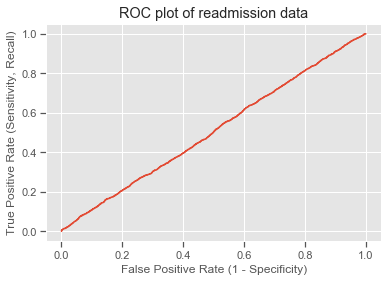

In [73]:
tpr, fpr, thresholds = roc_curve(y_pred, y_test)
plt.plot(fpr,tpr)
plt.xlabel("False Positive Rate (1 - Specificity)")
plt.ylabel("True Positive Rate (Sensitivity, Recall)")
plt.title("ROC plot of readmission data")
plt.show()

In [66]:
roc_auc_score(y_test, y_pred)

0.5028815439660086

In [76]:
y_test.sum()

2201

In [62]:
def roc_curve(prob, y):
    '''
    Build dataframe of the various confusion-matrix ratios by threshold
    from a list of predicted probabilities and actual y values
    '''
    df = pd.DataFrame({'prob': prob, 'y': y})
    df.sort_values('prob', inplace=True)
    
    actual_p = df.y.sum()
    actual_n = df.shape[0] - df.y.sum()

    df['tn'] = (df.y == 0).cumsum()
    df['fn'] = df.y.cumsum()
    df['fp'] = actual_n - df.tn
    df['tp'] = actual_p - df.fn

    df['fpr'] = df.fp/(df.fp + df.tn)
    df['tpr'] = df.tp/(df.tp + df.fn)
    df['precision'] = df.tp/(df.tp + df.fp)
    df = df.reset_index(drop=True)
    return df.tpr, df.fpr, prob

### GridSearchCV 

In [92]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix

import matplotlib.pyplot as plt
plt.style.use("ggplot")


In [94]:
df2 = df1

In [101]:
df2.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted_<30d'],
      dtype='object')

In [105]:
lb = LabelBinarizer()
df2['readmitted_<30d'] = lb.fit_transform(df2['readmitted_<30d'].values)
targets = df2['readmitted_<30d']
feat = df2.drop(['encounter_id', 'patient_nbr', 'readmitted_<30d'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(feat, targets, stratify=targets)

In [99]:
df2.drop(['diag_1', 'diag_2', 'diag_3'], axis=1, inplace=True)